<a href="https://colab.research.google.com/github/JavierAlbert/Variational_Autoencoders/blob/master/variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder

We will explore the use of a variational autoencoder on the Fashion-MNIST database. We will focus on the generative side of a variational autoencoder and we will sample the latent space to visualize how the different classes are arranged.

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from scipy.stats import norm

import keras
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend as K
from keras.datasets import mnist, fashion_mnist
K.clear_session()

## Import dataset

In [0]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
img_h = x_train.shape[1]
img_w = x_train.shape[2]

# Reshape images
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), img_h, img_w, 1))
x_test = np.reshape(x_test, (len(x_test), img_h, img_w, 1))

In [0]:
img_shape = (img_h, img_w, 1) # Image size
batch_size = 16 # Batch size
latent_dim = 2  # Latent space size

## Encoder architecture:
- Input - 28 by 28 images
- Conv2D - 32 kernels of 3 by 3, ReLu and same padding
- Conv2D - 64 kernels of 3 by 3, ReLu and same padding
- Conv2D - 64 kernels of 3 by 3, ReLu and same padding
- Conv2D - 64 kernerls of 3 by 3, ReLu and same padding
- Flatten
- Dense - 32 neurons
- Dense1 - 2 neurons (mean latent space)
- Dense2 - 2 neurons (sigma latent space)

In [0]:
# Input
input_img = keras.Input(shape=img_shape)

# Convolutional Layers
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)

# Save the shape of the network at this stage
shape_before_flattening = K.int_shape(x)

# Flatten + Dense
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

## Let's define our latent space sampling function 

In [0]:
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim))
    value = z_mu + K.exp(z_log_sigma) * epsilon 
    return value

## Decoder architecture

In [0]:
# Sample the latent space to get z
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

# Use the sample as input to the decoder
decoder_input = layers.Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)

# Reshape
x = layers.Reshape(shape_before_flattening[1:])(x)

# Use Conv2DTranspose to reverse the conv layers
x = layers.Conv2DTranspose(32, (3,3), padding='same', strides=(2, 2), activation='relu')(x)
x = layers.Conv2D(1, (3,3), padding='same', activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

## Custom loss function

In [0]:
# custom loss function
class CustomVariationalLayer(keras.layers.Layer):
    
    # VAE loss as sum of mean loss between input image and reconstructed image
    # plus a KL divergence term for the latent space
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [65]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (

In [66]:
vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=5,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 46s 759us/step - loss: 232.1351 - val_loss: 0.3414
Epoch 2/5
60000/60000 [==============================] - 44s 737us/step - loss: 0.3356 - val_loss: 0.3351
Epoch 3/5
60000/60000 [==============================] - 44s 737us/step - loss: 0.3326 - val_loss: 0.3355
Epoch 4/5
60000/60000 [==============================] - 44s 737us/step - loss: 0.3333 - val_loss: 0.3345
Epoch 5/5
60000/60000 [==============================] - 44s 738us/step - loss: 0.3295 - val_loss: 0.3329


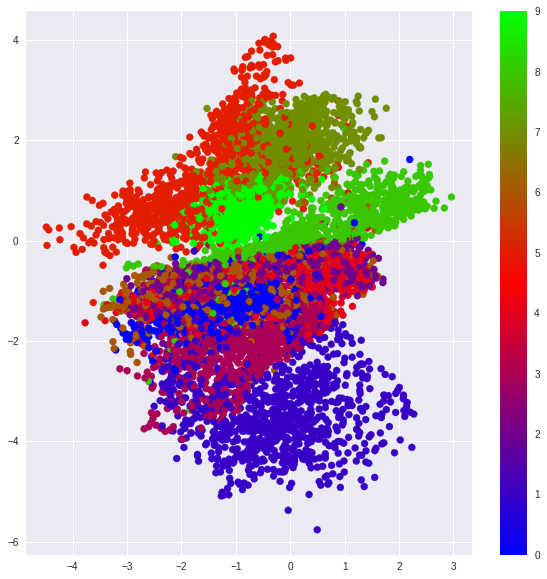

In [71]:
# Translate into the latent space
encoder = Model(input_img, z_mu)
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='brg')
plt.colorbar()
plt.show()

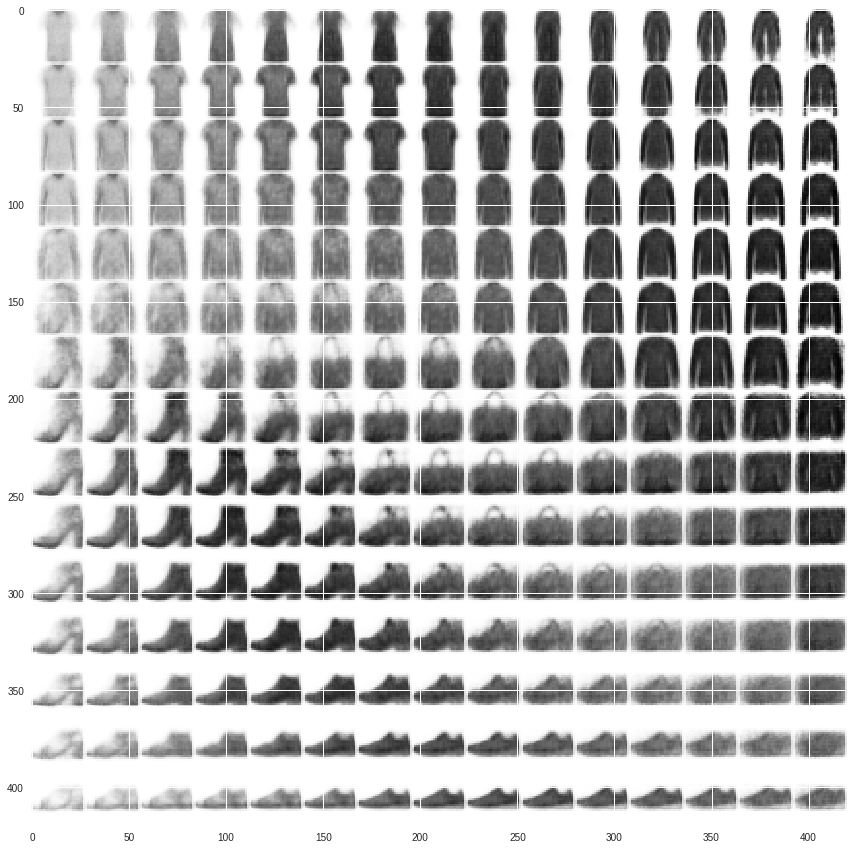

In [72]:
# Display a 2D manifold of the digits
n = 15# figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(15, 15))
plt.imshow(figure)
plt.show()